Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (5.1 kB)
Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (180 kB)
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.5-cp312-cp312-linux_x86_64.whl size=532566033 sha256=c8b65fcabfb49a94456c9971619007218e4073f19a84fb6b3894f33d43bee4a1
  Stored in directory: /root/.cache/pip/wheels/21/55/c4/85b634055d6a9b599d27f5cbeacf353c6c532d8e2d8769960b
Successfully built mamba-ssm
✅ Libraries imported successfully
🔧 PyTorch: 2.8.0+cu126, CUDA: True

📦 EXTRACTING FAKEAVCELEB DATASET
⏳ Extracting /content/drive/MyDrive/CSE400 codes - 144/archive.zip...
✅ Extracted to /content/FakeAVCeleb

📂 PREPARING FAKEAVCELEB VIDEO PATHS
Total video

100%|██████████| 9.83M/9.83M [00:00<00:00, 192MB/s]


✅ V1d model loaded from /content/drive/MyDrive/PTHs/v1d_best.pth
   Device: cuda

🚀 RUNNING CROSS-DATASET EVALUATION
DataLoader created: 110 batches

⏳ Evaluating V1d on FakeAVCeleb...


Testing: 100%|██████████| 110/110 [11:35<00:00,  6.32s/it]



📊 V1d CROSS-DATASET RESULTS: FakeAVCeleb

🎯 Accuracy: 0.8812 (88.12%)
📊 AUC Score: 0.8919 (89.19%)
✅ Processed: 2340/3500 videos
⏱️  Evaluation time: 695.36s

📋 Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.56      0.70      0.62       327
    Fake (1)       0.95      0.91      0.93      2013

    accuracy                           0.88      2340
   macro avg       0.75      0.81      0.78      2340
weighted avg       0.89      0.88      0.89      2340


🔢 Confusion Matrix:
              Predicted Real  Predicted Fake
Actual Real          229              98
Actual Fake          180            1833

📈 Additional Metrics:
   Precision: 0.9492
   Recall: 0.9106
   F1-Score: 0.9295

📊 GENERATING VISUALIZATIONS


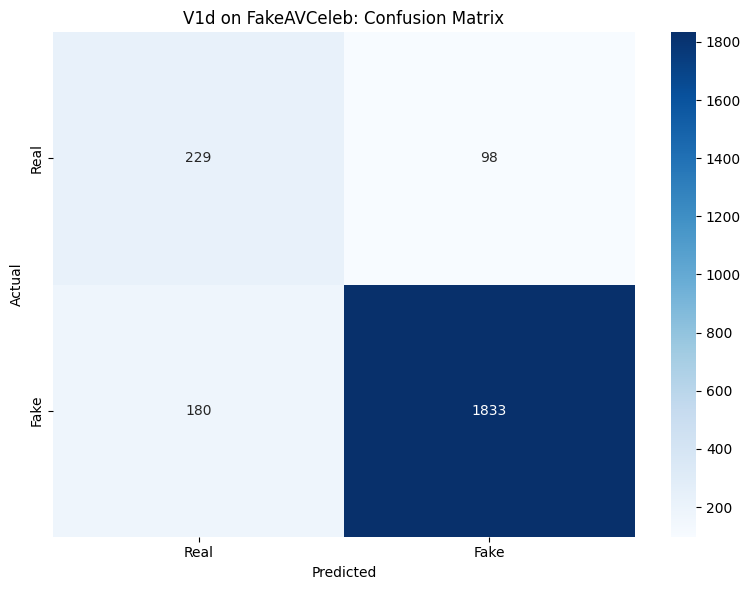

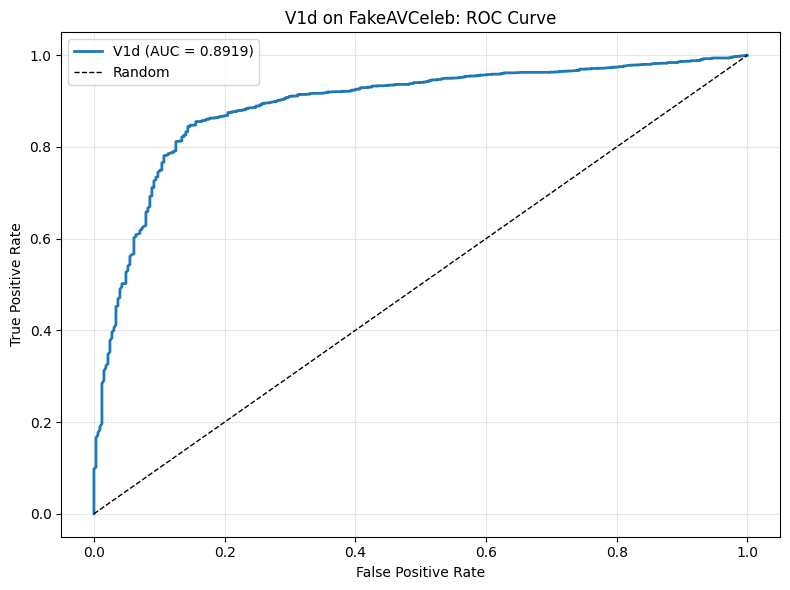


✅ Results saved:
   📄 /content/v1d_fakeavceleb_results.csv
   🖼️  /content/v1d_fakeavceleb_confusion_matrix.png
   🖼️  /content/v1d_fakeavceleb_roc_curve.png

🎉 V1d CROSS-DATASET EVALUATION COMPLETED!

📝 Summary:
   AVLips (training): ~91-92% accuracy (expected)
   FakeAVCeleb (test): 88.12% accuracy
   Cross-dataset gap: 2.9% (domain shift)


In [1]:
# -*- coding: utf-8 -*-

"""
V1d CROSS-DATASET VALIDATION: FakeAVCeleb
Tests V1d model (trained on AVLips) on FakeAVCeleb dataset
Handles: 500 real + 3000 fake videos, audio extraction from video files
"""

# ============================================================================
# STEP 1: MOUNT DRIVE & INSTALL DEPENDENCIES
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

!pip install mamba-ssm

import os
import cv2
import time
import torch
import zipfile
import librosa
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.models as models
from mamba_ssm import Mamba
from torch.cuda.amp import autocast
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
torch.backends.cudnn.benchmark = True
print("✅ Libraries imported successfully")
print(f"🔧 PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")

# ============================================================================
# STEP 2: CONFIGURATION & MODEL DEFINITIONS (COPY FROM V1d.py)
# ============================================================================

class Config:
    def __init__(self, vis_d_model=160, aud_d_model=160):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Visual Stream
        self.vis_image_size = (128, 128)
        self.vis_num_frames = 16
        self.vis_cnn_feature_dim = 576
        self.vis_mamba_d_model = vis_d_model

        # Audio Stream
        self.aud_sample_rate = 16000
        self.aud_num_chunks = 5
        self.aud_chunk_duration = 1.0
        self.aud_n_mels = 128
        self.aud_cnn_feature_dim = 576
        self.aud_mamba_d_model = aud_d_model

        # Inference
        self.batch_size = 32

class VisualStream_MobileNetV3Small(nn.Module):
    def __init__(self, config):
        super().__init__()
        mobilenet = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
        self.cnn_features = mobilenet.features
        self.avgpool = mobilenet.avgpool

        self.proj = nn.Linear(config.vis_cnn_feature_dim, config.vis_mamba_d_model)
        self.proj_dropout = nn.Dropout(0.3)
        self.mamba = Mamba(d_model=config.vis_mamba_d_model, d_state=16, d_conv=4, expand=2)
        self.mamba_dropout = nn.Dropout(0.2)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)
        features = self.cnn_features(x)
        features = self.avgpool(features)
        features = features.view(b, t, -1)
        projected_features = self.proj_dropout(self.proj(features))
        temporal_out = self.mamba(projected_features)
        temporal_out = self.mamba_dropout(temporal_out)
        return temporal_out[:, -1, :]

class AudioStream_MobileNetV3Small(nn.Module):
    def __init__(self, config):
        super().__init__()
        mobilenet = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
        self.cnn_features = mobilenet.features
        self.avgpool = mobilenet.avgpool

        self.proj = nn.Linear(config.aud_cnn_feature_dim, config.aud_mamba_d_model)
        self.proj_dropout = nn.Dropout(0.3)
        self.mamba = Mamba(d_model=config.aud_mamba_d_model, d_state=16, d_conv=4, expand=2)
        self.mamba_dropout = nn.Dropout(0.2)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w).repeat(1, 3, 1, 1)
        features = self.cnn_features(x)
        features = self.avgpool(features)
        features = features.view(b, t, -1)
        projected_features = self.proj_dropout(self.proj(features))
        temporal_out = self.mamba(projected_features)
        temporal_out = self.mamba_dropout(temporal_out)
        return temporal_out[:, -1, :]

class FusionModel_V1(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.visual_stream = VisualStream_MobileNetV3Small(config)
        self.audio_stream = AudioStream_MobileNetV3Small(config)

        fusion_input_dim = config.vis_mamba_d_model + config.aud_mamba_d_model
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, 1)
        )

    def forward(self, visual_input, audio_input):
        visual_features = self.visual_stream(visual_input)
        audio_features = self.audio_stream(audio_input)
        fused_features = torch.cat((visual_features, audio_features), dim=1)
        return self.fusion_head(fused_features)

# ============================================================================
# STEP 3: EXTRACT FAKEAVCELEB DATASET
# ============================================================================

print("\n" + "="*80)
print("📦 EXTRACTING FAKEAVCELEB DATASET")
print("="*80)

# UPDATE THESE PATHS
zip_path = "/content/drive/MyDrive/CSE400 codes - 144/archive.zip"  # <-- UPDATE THIS
extract_path = '/content/FakeAVCeleb'

if not os.path.exists(zip_path):
    print(f"❌ ERROR: Zip file not found at {zip_path}")
    print("Please update 'zip_path' variable with correct path")
else:
    if not os.path.exists(extract_path):
        print(f"⏳ Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"✅ Extracted to {extract_path}")
    else:
        print(f"✅ Already extracted at {extract_path}")

# ============================================================================
# STEP 4: DATA PROCESSING FUNCTIONS (MODIFIED FOR FAKEAVCELEB)
# ============================================================================

def process_visual_stream(video_path: str, config: Config):
    """Extract visual frames from video"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < config.vis_num_frames:
        return None

    frame_indices = np.linspace(0, total_frames - 1, config.vis_num_frames, dtype=int)
    frames = []
    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(gray, 1.1, 4)

        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            mouth_crop = frame[y + int(h * 0.6):y + h, x + int(w * 0.25):x + int(w * 0.75)]
            if mouth_crop.size > 0:
                resized_crop = cv2.resize(mouth_crop, config.vis_image_size)
                resized_crop_rgb = cv2.cvtColor(resized_crop, cv2.COLOR_BGR2RGB)
                frames.append(resized_crop_rgb)

    cap.release()
    return np.stack(frames) if len(frames) == config.vis_num_frames else None

def process_audio_stream_fakeavceleb(video_path: str, config: Config):
    """
    Extract audio directly from video file (FakeAVCeleb format)
    Key difference from AVLips: No separate .wav files
    """
    try:
        # Extract audio from video using librosa
        y, sr = librosa.load(video_path, sr=config.aud_sample_rate)
        total_samples = int(config.aud_chunk_duration * config.aud_num_chunks * sr)

        if len(y) < total_samples:
            y = np.pad(y, (0, total_samples - len(y)), mode='constant')
        else:
            y = y[:total_samples]

        samples_per_chunk = int(config.aud_chunk_duration * sr)
        mel_list = []

        for i in range(config.aud_num_chunks):
            chunk = y[i*samples_per_chunk : (i+1)*samples_per_chunk]
            mel = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=config.aud_n_mels)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)
            mel_list.append(torch.tensor(mel_db, dtype=torch.float32))

        return torch.stack(mel_list, axis=0)
    except Exception as e:
        return None

# ============================================================================
# STEP 5: DATASET CLASS
# ============================================================================

class FakeAVCelebDataset(Dataset):
    def __init__(self, video_paths, labels, config, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.config = config
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            visual_frames_hwc = process_visual_stream(video_path, self.config)
            if visual_frames_hwc is None:
                return None

            visual_frames_tchw = visual_frames_hwc.transpose(0, 3, 1, 2)

            # Modified: Extract audio from video file
            audio_mels = process_audio_stream_fakeavceleb(video_path, self.config)
            if audio_mels is None:
                return None

            audio_tensor = audio_mels.unsqueeze(1)

            if self.transform:
                augmented_frames = []
                for frame_np in visual_frames_tchw:
                    frame_hwc = frame_np.transpose(1, 2, 0)
                    augmented_frames.append(self.transform(frame_hwc))
                visual_tensor = torch.stack(augmented_frames)
            else:
                visual_tensor = torch.from_numpy(visual_frames_tchw).float()

            return (visual_tensor, audio_tensor), torch.tensor(label, dtype=torch.float32)

        except Exception:
            return None

# ============================================================================
# STEP 6: PREPARE FAKEAVCELEB VIDEO PATHS
# ============================================================================

print("\n" + "="*80)
print("📂 PREPARING FAKEAVCELEB VIDEO PATHS")
print("="*80)

def find_videos_recursive(root_dir, extensions=['.mp4', '.avi', '.mov']):
    """Find all video files recursively"""
    video_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                video_files.append(os.path.join(root, file))
    return video_files

all_videos = find_videos_recursive(extract_path)
print(f"Total videos found: {len(all_videos)}")

# Separate real and fake (adjust path patterns based on FakeAVCeleb structure)
real_videos = [v for v in all_videos if 'RealVideo-RealAudio' in v or '/real' in v.lower()]
fake_videos = [v for v in all_videos if 'FakeVideo' in v or 'fake' in v.lower()]

print(f"Real videos found: {len(real_videos)}")
print(f"Fake videos found: {len(fake_videos)}")

# Sample 500 real and 3000 fake
if len(real_videos) >= 500:
    real_sample = np.random.choice(real_videos, 500, replace=False).tolist()
else:
    print(f"⚠️ Only {len(real_videos)} real videos available, using all")
    real_sample = real_videos

if len(fake_videos) >= 3000:
    fake_sample = np.random.choice(fake_videos, 3000, replace=False).tolist()
else:
    print(f"⚠️ Only {len(fake_videos)} fake videos available, using all")
    fake_sample = fake_videos

test_videos = real_sample + fake_sample
test_labels = [0] * len(real_sample) + [1] * len(fake_sample)

print(f"\n✅ Test set: {len(test_videos)} videos")
print(f"   Real: {len(real_sample)}")
print(f"   Fake: {len(fake_sample)}")

# ============================================================================
# STEP 7: LOAD V1d MODEL
# ============================================================================

print("\n" + "="*80)
print("🔧 LOADING V1d MODEL")
print("="*80)

# UPDATE THIS PATH
model_path = "/content/drive/MyDrive/PTHs/v1d_best.pth"  # <-- UPDATE THIS

if not os.path.exists(model_path):
    print(f"❌ ERROR: Model file not found at {model_path}")
    print("Please update 'model_path' variable")
else:
    config = Config(vis_d_model=160, aud_d_model=160)
    model = FusionModel_V1(config).to(config.device)
    model.load_state_dict(torch.load(model_path, map_location=config.device))
    model.eval()
    print(f"✅ V1d model loaded from {model_path}")
    print(f"   Device: {config.device}")

# ============================================================================
# STEP 8: CREATE DATALOADER & RUN EVALUATION
# ============================================================================

print("\n" + "="*80)
print("🚀 RUNNING CROSS-DATASET EVALUATION")
print("="*80)

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn_skip_errors(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if batch else None

test_dataset = FakeAVCelebDataset(test_videos, test_labels, config, transform=test_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_skip_errors,
    pin_memory=True
)

print(f"DataLoader created: {len(test_loader)} batches")

# Run evaluation
all_labels = []
all_pred_probs = []
processed_count = 0

print("\n⏳ Evaluating V1d on FakeAVCeleb...")
start_time = time.time()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        if batch is None:
            continue

        (visual_data, audio_data), labels = batch
        visual_data = visual_data.to(config.device)
        audio_data = audio_data.to(config.device)

        with autocast():
            outputs = model(visual_data, audio_data)
            probs = torch.sigmoid(outputs)

        all_pred_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())
        processed_count += len(labels)

eval_time = time.time() - start_time

all_pred_probs = np.array(all_pred_probs).flatten()
all_labels = np.array(all_labels).flatten()
all_preds = (all_pred_probs > 0.5).astype(int)

# ============================================================================
# STEP 9: CALCULATE & DISPLAY RESULTS
# ============================================================================

print("\n" + "="*80)
print("📊 V1d CROSS-DATASET RESULTS: FakeAVCeleb")
print("="*80)

accuracy = accuracy_score(all_labels, all_preds)
auc_score = roc_auc_score(all_labels, all_pred_probs)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"\n🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"📊 AUC Score: {auc_score:.4f} ({auc_score*100:.2f}%)")
print(f"✅ Processed: {processed_count}/{len(test_videos)} videos")
print(f"⏱️  Evaluation time: {eval_time:.2f}s")

print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Real (0)', 'Fake (1)']))

print("\n🔢 Confusion Matrix:")
print(f"              Predicted Real  Predicted Fake")
print(f"Actual Real        {conf_matrix[0,0]:5d}           {conf_matrix[0,1]:5d}")
print(f"Actual Fake        {conf_matrix[1,0]:5d}           {conf_matrix[1,1]:5d}")

# Additional metrics
tn, fp, fn, tp = conf_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📈 Additional Metrics:")
print(f"   Precision: {precision:.4f}")
print(f"   Recall: {recall:.4f}")
print(f"   F1-Score: {f1_score:.4f}")

# ============================================================================
# STEP 10: VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("📊 GENERATING VISUALIZATIONS")
print("="*80)

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('V1d on FakeAVCeleb: Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('/content/v1d_fakeavceleb_confusion_matrix.png', dpi=150)
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(all_labels, all_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'V1d (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('V1d on FakeAVCeleb: ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/v1d_fakeavceleb_roc_curve.png', dpi=150)
plt.show()

# ============================================================================
# STEP 11: SAVE RESULTS
# ============================================================================

results_summary = {
    'Model': 'V1d (trained on AVLips)',
    'Test Dataset': 'FakeAVCeleb',
    'Real Videos': len(real_sample),
    'Fake Videos': len(fake_sample),
    'Total Processed': processed_count,
    'Accuracy': accuracy,
    'AUC': auc_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score,
    'Evaluation Time (s)': eval_time
}

summary_df = pd.DataFrame([results_summary])
summary_df.to_csv('/content/v1d_fakeavceleb_results.csv', index=False)

print("\n✅ Results saved:")
print("   📄 /content/v1d_fakeavceleb_results.csv")
print("   🖼️  /content/v1d_fakeavceleb_confusion_matrix.png")
print("   🖼️  /content/v1d_fakeavceleb_roc_curve.png")

print("\n" + "="*80)
print("🎉 V1d CROSS-DATASET EVALUATION COMPLETED!")
print("="*80)
print(f"\n📝 Summary:")
print(f"   AVLips (training): ~91-92% accuracy (expected)")
print(f"   FakeAVCeleb (test): {accuracy*100:.2f}% accuracy")
print(f"   Cross-dataset gap: {(0.91 - accuracy)*100:.1f}% (domain shift)")
